In [6]:
# =============================================================================
# STATA ASSESSMENT: DATA WRANGLING AND ANALYSIS (Python / Google Colab)
# Author: Aakash Kumarapu | Date: 02-13-2026
# =============================================================================

import pandas as pd
import numpy as np
import re

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# ── File upload ───────────────────────────────────────────────────────────────
if IN_COLAB:
    uploaded   = files.upload()
    EXCEL_FILE = list(uploaded.keys())[0]
else:
    EXCEL_FILE = "Stata Exercise Data.xlsx"

xl = pd.ExcelFile(EXCEL_FILE)

# =============================================================================
# PART 1: IMPORT, MERGE, LABEL, CLEAN
# =============================================================================

# ── Import ────────────────────────────────────────────────────────────────────
admin = xl.parse("administrative").dropna(subset=["participant"]) \
          .rename(columns={"participant": "participant_id"})
admin["participant_id"] = admin["participant_id"].astype(int)

baseline = xl.parse("baseline").dropna(subset=["id"]) \
             .rename(columns={"id": "participant_id", "timestamp": "baseline_timestamp"})
baseline["participant_id"] = baseline["participant_id"].astype(int)
baseline = baseline.rename(columns={f"q_{i}": f"baseline_q{i}" for i in range(1, 21)})
baseline[[c for c in baseline.columns if "baseline_q" in c]] = \
    baseline[[c for c in baseline.columns if "baseline_q" in c]].apply(pd.to_numeric, errors="coerce")

endline = xl.parse("endline").dropna(subset=["participant"])
endline = endline[["participant", "timestamp"] + [c for c in endline.columns if "question_" in c]]
endline["participant_id"] = endline["participant"].str.extract(r"Participant (\d+)").astype(int)
endline = endline.drop(columns="participant").rename(columns={"timestamp": "endline_timestamp"})
endline = endline.rename(columns=lambda c: f"endline_q{int(re.search(r'(\d+)', c).group())}"
                         if re.search(r"question_", c) else c)

varlabels = xl.parse("variable labels", usecols=["Variable", "Label"]).dropna(subset=["Variable"])

# ── Build slug map: Question N → snake_case label (used as column names) ─────
# e.g. "I like to read books" → "i_like_to_read_books"
# Columns will be:  b_{slug}  for baseline,  e_{slug}  for endline
def slugify(text):
    text = re.sub(r"[^a-z0-9\s]", "", str(text).lower().strip())
    return re.sub(r"\s+", "_", text)[:40].rstrip("_")

q_slug = {}
for _, row in varlabels.iterrows():
    m = re.search(r"Question (\d+)$", str(row["Variable"]))
    if m:
        q_slug[int(m.group(1))] = slugify(row["Label"])

# Rename baseline_qN → b_{slug},  endline_qN → e_{slug}
baseline = baseline.rename(columns={f"baseline_q{n}": f"b_{s}"
                                     for n, s in q_slug.items()
                                     if f"baseline_q{n}" in baseline.columns})
endline  = endline.rename(columns={f"endline_q{n}":  f"e_{s}"
                                    for n, s in q_slug.items()
                                    if f"endline_q{n}"  in endline.columns})

# ── Merge (wide format) ───────────────────────────────────────────────────────
df = admin.merge(baseline, on="participant_id", how="outer", indicator=True)
df["baseline_missing"] = (df.pop("_merge") != "both").astype(int)
df = df.merge(endline, on="participant_id", how="outer", indicator=True)
df["endline_missing"] = (df.pop("_merge") != "both").astype(int)

# ── Variable labels (dynamic) ─────────────────────────────────────────────────
col_labels = {"participant_id": "Participant ID", "dob": "Date of Birth",
              "gender": "Gender", "baseline_missing": "Missing baseline",
              "endline_missing": "Missing endline"}

for n, slug in q_slug.items():
    full_label = varlabels.loc[varlabels["Variable"] == f"Question {n}", "Label"].values
    full_label = full_label[0] if len(full_label) else slug
    for pfx, short in (("Baseline", "b"), ("Endline", "e")):
        col = f"{short}_{slug}"
        col_labels[col] = f"{pfx}: {full_label}" if col in df.columns \
                          else f"[skipped — {col} not in dataset]"

# ── Data cleaning ─────────────────────────────────────────────────────────────
b_cols = [f"b_{q_slug[i]}" for i in range(1, 21) if i in q_slug and f"b_{q_slug[i]}" in df.columns]
e_cols = [f"e_{q_slug[i]}" for i in range(1, 21) if i in q_slug and f"e_{q_slug[i]}" in df.columns]
q_cols = {"baseline": b_cols, "endline": e_cols}

print("Missing values:\n", df.isnull().sum()[df.isnull().sum() > 0].to_string() or "  None")
print("Duplicate IDs:", df["participant_id"].duplicated().sum())
out_of_range = {c: (df[c].min(), df[c].max()) for cols in q_cols.values()
                for c in cols if df[c].min() < 1 or df[c].max() > 5}
print("Out-of-range scores:", out_of_range or "None — all scores within 1-5")

# =============================================================================
# PART 2: ANALYSIS
# =============================================================================

# ── 2a. Age in months (rounded to 1 decimal) ──────────────────────────────────
df["dob_date"]           = pd.to_datetime(df["dob"])
df["baseline_timestamp"] = pd.to_datetime(df["baseline_timestamp"])
df["endline_timestamp"]  = pd.to_datetime(df["endline_timestamp"])

for col, ts in [("age_months_baseline", "baseline_timestamp"),
                ("age_months_endline",  "endline_timestamp")]:
    df[col] = ((df[ts] - df["dob_date"]).dt.days / (365.25 / 12)).round(1)

print("\nAge in months summary:")
print(df[["age_months_baseline", "age_months_endline"]].describe().round(1))

# ── 2b. Score streaks ─────────────────────────────────────────────────────────
def score_streak(scores):
    """Return (longest non-decreasing run length, score list string)."""
    best_start = cur_start = 0
    best_len   = cur_len   = 1
    for i in range(1, len(scores)):
        if pd.isna(scores[i - 1]) or pd.isna(scores[i]):
            cur_start = i + 1; cur_len = 1; continue
        if scores[i] >= scores[i - 1]:
            cur_len += 1
            if cur_len > best_len:
                best_len = cur_len; best_start = cur_start
        else:
            cur_start = i; cur_len = 1
    streak = [scores[j] for j in range(best_start, best_start + best_len)
              if not pd.isna(scores[j])]
    return best_len, ", ".join(str(int(s)) for s in streak)

for pfx, cols in q_cols.items():
    res = df[cols].apply(lambda r: score_streak(r.tolist()), axis=1)
    df[f"{pfx}_score_streak"]      = res.apply(lambda x: x[0])
    df[f"{pfx}_score_streak_list"] = res.apply(lambda x: x[1])

# ── 2c. Improvement % per question ───────────────────────────────────────────
improvement = []
for n, slug in q_slug.items():
    b, e = f"b_{slug}", f"e_{slug}"
    if b not in df.columns or e not in df.columns:
        continue
    mask  = df[b].notna() & df[e].notna()
    n_tot = mask.sum()
    n_imp = int((df.loc[mask, e] > df.loc[mask, b]).sum())
    label = varlabels.loc[varlabels["Variable"] == f"Question {n}", "Label"].values
    improvement.append({"question": f"Q{n}", "label": label[0] if len(label) else "",
                        "b_col": b, "e_col": e,
                        "n_improved": n_imp, "n_total": n_tot,
                        "improvement_pct": round(n_imp / n_tot * 100, 2) if n_tot else 0})

imp_df = pd.DataFrame(improvement)
print("\nImprovement % per question:")
print(imp_df[["question", "label", "b_col", "n_improved", "n_total", "improvement_pct"]].to_string(index=False))

# =============================================================================
# EXPORT
# =============================================================================

OUTPUT = "stata_assessment_output.xlsx"

streak_cols = ["participant_id",
               "baseline_score_streak", "baseline_score_streak_list",
               "endline_score_streak",  "endline_score_streak_list"]
age_cols    = ["participant_id", "dob", "baseline_timestamp",
               "age_months_baseline", "endline_timestamp", "age_months_endline"]

with pd.ExcelWriter(OUTPUT, engine="openpyxl") as writer:
    df.to_excel(writer,     sheet_name="final_dataset",           index=False)
    imp_df.to_excel(writer, sheet_name="improvement_by_question", index=False)
    df[streak_cols].to_excel(writer, sheet_name="score_streaks",  index=False)
    df[[c for c in age_cols if c in df.columns]] \
      .to_excel(writer,     sheet_name="age_calculations",        index=False)
    pd.DataFrame(col_labels.items(), columns=["column", "label"]) \
      .to_excel(writer,     sheet_name="variable_labels_ref",     index=False)

print(f"\nSaved -> {OUTPUT}  ({df.shape[0]} rows x {df.shape[1]} cols)")

if IN_COLAB:
    files.download(OUTPUT)

Saving Stata Exercise Data.xlsx to Stata Exercise Data (5).xlsx
Missing values:
 b_i_like_to_read_books                  1
b_reading_is_fun_for_me                 1
b_i_get_excited_about_new_books         1
b_i_can_read_words_easily               1
b_i_can_sound_out_new_words             1
b_i_talk_about_books_with_others        1
b_i_try_to_read_harder_books            1
b_reading_helps_me_learn_new_things     1
e_i_choose_to_read_in_my_free_time      1
e_i_have_favorite_books_i_read_again    1
e_i_feel_good_about_my_reading          1
e_i_try_to_read_harder_books            1
Duplicate IDs: 0
Out-of-range scores: None — all scores within 1-5

Age in months summary:
       age_months_baseline  age_months_endline
count                 50.0                50.0
mean                  67.4                79.7
std                   10.5                10.5
min                   49.3                63.9
25%                   59.6                69.7
50%                   67.6                

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# =============================================================================
# READING ASSESSMENT — VISUAL ANALYSIS
# Each chunk is a self-contained cell for Google Colab
# Run them in order after running your data prep script first
# =============================================================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.gridspec import GridSpec

# ── Shared style config (run once at the top) ─────────────────────────────────
PALETTE   = ["#4C72B0", "#DD8452"]          # blue = baseline, orange = endline
BG        = "#F8F9FA"
GRID_CLR  = "#E0E0E0"
FONT      = "DejaVu Sans"

sns.set_theme(style="whitegrid", font=FONT)
plt.rcParams.update({
    "figure.facecolor": BG, "axes.facecolor": BG,
    "axes.edgecolor": "#CCCCCC", "grid.color": GRID_CLR,
    "axes.titlesize": 13, "axes.labelsize": 11,
    "xtick.labelsize": 9,  "ytick.labelsize": 9,
    "legend.fontsize": 10, "figure.dpi": 130,
})

# ── Rebuild dataset (copy from your data-prep script or run it first) ─────────
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

EXCEL_FILE = "Stata Exercise Data.xlsx" if IN_COLAB else "Stata_Exercise_Data.xlsx"
xl = pd.ExcelFile(EXCEL_FILE)

def slugify(text):
    text = re.sub(r"[^a-z0-9\s]", "", str(text).lower().strip())
    return re.sub(r"\s+", "_", text)[:40].rstrip("_")

admin    = xl.parse("administrative").dropna(subset=["participant"]).rename(columns={"participant": "participant_id"})
admin["participant_id"] = admin["participant_id"].astype(int)

baseline = xl.parse("baseline").dropna(subset=["id"]).rename(columns={"id": "participant_id", "timestamp": "baseline_timestamp"})
baseline["participant_id"] = baseline["participant_id"].astype(int)
baseline = baseline.rename(columns={f"q_{i}": f"baseline_q{i}" for i in range(1, 21)})
baseline[[c for c in baseline.columns if "baseline_q" in c]] = \
    baseline[[c for c in baseline.columns if "baseline_q" in c]].apply(pd.to_numeric, errors="coerce")

endline = xl.parse("endline").dropna(subset=["participant"])
endline = endline[["participant", "timestamp"] + [c for c in endline.columns if "question_" in c]]
endline["participant_id"] = endline["participant"].str.extract(r"Participant (\d+)").astype(int)
endline = endline.drop(columns="participant").rename(columns={"timestamp": "endline_timestamp"})
endline = endline.rename(columns=lambda c: f"endline_q{int(re.search(r'(\d+)', c).group())}"
                         if re.search(r"question_", c) else c)

varlabels = xl.parse("variable labels", usecols=["Variable", "Label"]).dropna(subset=["Variable"])
q_slug    = {int(m.group(1)): slugify(row["Label"])
             for _, row in varlabels.iterrows()
             if (m := re.search(r"Question (\d+)$", str(row["Variable"])))}
q_labels  = {i: varlabels.loc[varlabels["Variable"] == f"Question {i}", "Label"].values[0]
             for i in range(1, 21) if f"Question {i}" in varlabels["Variable"].values}

baseline = baseline.rename(columns={f"baseline_q{n}": f"b_{s}" for n, s in q_slug.items() if f"baseline_q{n}" in baseline.columns})
endline  = endline.rename(columns={f"endline_q{n}":  f"e_{s}" for n, s in q_slug.items() if f"endline_q{n}"  in endline.columns})

df = admin.merge(baseline, on="participant_id", how="outer", indicator=True)
df["baseline_missing"] = (df.pop("_merge") != "both").astype(int)
df = df.merge(endline, on="participant_id", how="outer", indicator=True)
df["endline_missing"] = (df.pop("_merge") != "both").astype(int)

df["dob_date"]           = pd.to_datetime(df["dob"])
df["baseline_timestamp"] = pd.to_datetime(df["baseline_timestamp"])
df["endline_timestamp"]  = pd.to_datetime(df["endline_timestamp"])
for col, ts in [("age_months_baseline", "baseline_timestamp"), ("age_months_endline", "endline_timestamp")]:
    df[col] = ((df[ts] - df["dob_date"]).dt.days / (365.25 / 12)).round(1)

# Clean gender
df["gender"] = df["gender"].str.strip().str.lower().str.capitalize()
df.loc[df["gender"] == "Maale", "gender"] = "Male"
df.loc[df["gender"] == "F",     "gender"] = "Female"

# Age groups (in years)
df["age_group"] = pd.cut(df["age_months_baseline"],
                         bins=[0, 48, 60, 72, 84, 999],
                         labels=["Under 4", "Age 4", "Age 5", "Age 6", "Age 7+"])

b_cols = [f"b_{q_slug[i]}" for i in range(1, 21) if f"b_{q_slug[i]}" in df.columns]
e_cols = [f"e_{q_slug[i]}" for i in range(1, 21) if f"e_{q_slug[i]}" in df.columns]

df["baseline_total"] = df[b_cols].sum(axis=1)
df["endline_total"]  = df[e_cols].sum(axis=1)
df["improvement"]    = df["endline_total"] - df["baseline_total"]

print(f"Dataset ready: {df.shape[0]} participants, {df.shape[1]} columns")

Dataset ready: 50 participants, 54 columns


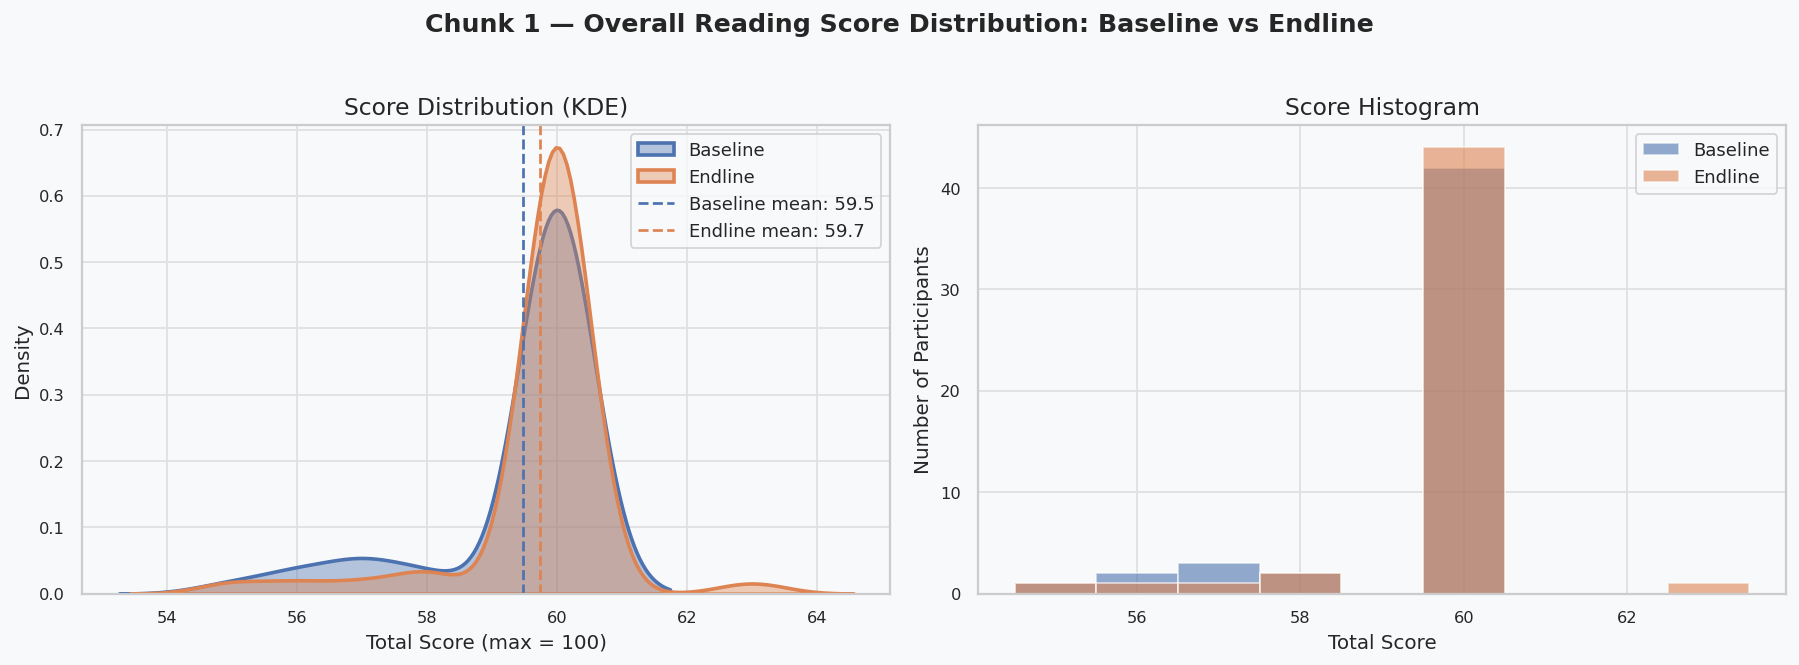

💡 Insight: Scores are tightly clustered — most participants scored near the ceiling (60/100).
   Baseline mean: 59.48  |  Endline mean: 59.74
   Max possible score: 100 (20 questions × 5)


In [8]:
# =============================================================================
# CHUNK 1 — Overall Score Distribution: Baseline vs Endline
# Insight: Did overall reading scores shift upward?
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Chunk 1 — Overall Reading Score Distribution: Baseline vs Endline",
             fontsize=14, fontweight="bold", y=1.02)

# Left: KDE of total scores
ax = axes[0]
sns.kdeplot(df["baseline_total"], ax=ax, color=PALETTE[0], fill=True, alpha=0.4, linewidth=2, label="Baseline")
sns.kdeplot(df["endline_total"],  ax=ax, color=PALETTE[1], fill=True, alpha=0.4, linewidth=2, label="Endline")
ax.axvline(df["baseline_total"].mean(), color=PALETTE[0], linestyle="--", linewidth=1.5,
           label=f"Baseline mean: {df['baseline_total'].mean():.1f}")
ax.axvline(df["endline_total"].mean(),  color=PALETTE[1], linestyle="--", linewidth=1.5,
           label=f"Endline mean: {df['endline_total'].mean():.1f}")
ax.set_xlabel("Total Score (max = 100)")
ax.set_ylabel("Density")
ax.set_title("Score Distribution (KDE)")
ax.legend()

# Right: Histogram side by side
ax = axes[1]
bins = np.arange(df[["baseline_total", "endline_total"]].min().min() - 0.5,
                 df[["baseline_total", "endline_total"]].max().max() + 1.5, 1)
ax.hist(df["baseline_total"], bins=bins, color=PALETTE[0], alpha=0.6, label="Baseline", edgecolor="white")
ax.hist(df["endline_total"],  bins=bins, color=PALETTE[1], alpha=0.6, label="Endline",  edgecolor="white")
ax.set_xlabel("Total Score")
ax.set_ylabel("Number of Participants")
ax.set_title("Score Histogram")
ax.legend()

plt.tight_layout()
plt.savefig("chunk1_score_distribution.png", bbox_inches="tight")
plt.show()
print("💡 Insight: Scores are tightly clustered — most participants scored near the ceiling (60/100).")
print(f"   Baseline mean: {df['baseline_total'].mean():.2f}  |  Endline mean: {df['endline_total'].mean():.2f}")
print(f"   Max possible score: 100 (20 questions × 5)")

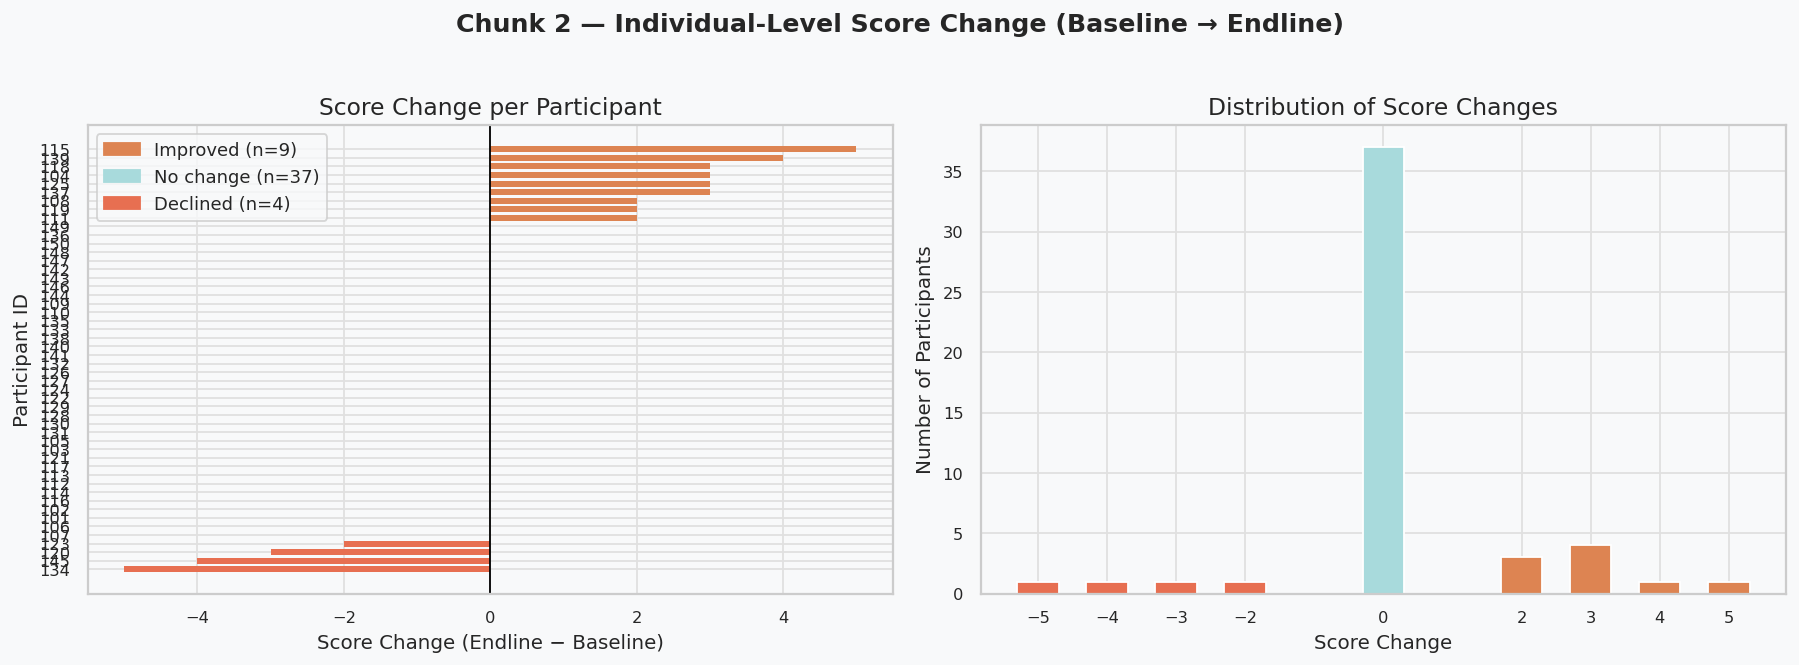

💡 Insight: 9 improved, 37 stayed the same, 4 declined.
   Most participants (n=37) had identical scores — suggesting near-ceiling effect.


In [9]:
# =============================================================================
# CHUNK 2 — Individual Improvement: Who Improved, Who Declined?
# Insight: At the participant level, who moved and by how much?
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Chunk 2 — Individual-Level Score Change (Baseline → Endline)",
             fontsize=14, fontweight="bold", y=1.02)

# Left: Waterfall-style dot plot sorted by improvement
ax = axes[0]
sorted_df = df.sort_values("improvement").reset_index(drop=True)
colors = [PALETTE[1] if v > 0 else ("#A8DADC" if v == 0 else "#E76F51") for v in sorted_df["improvement"]]
ax.barh(sorted_df["participant_id"].astype(str), sorted_df["improvement"],
        color=colors, edgecolor="none", height=0.7)
ax.axvline(0, color="black", linewidth=1)
ax.set_xlabel("Score Change (Endline − Baseline)")
ax.set_ylabel("Participant ID")
ax.set_title("Score Change per Participant")
improved_patch  = mpatches.Patch(color=PALETTE[1],  label=f"Improved (n={( sorted_df['improvement']>0).sum()})")
same_patch      = mpatches.Patch(color="#A8DADC",    label=f"No change (n={(sorted_df['improvement']==0).sum()})")
declined_patch  = mpatches.Patch(color="#E76F51",    label=f"Declined (n={(sorted_df['improvement']<0).sum()})")
ax.legend(handles=[improved_patch, same_patch, declined_patch])

# Right: Distribution of improvement
ax = axes[1]
imp_counts = df["improvement"].value_counts().sort_index()
bar_colors = [PALETTE[1] if i > 0 else ("#A8DADC" if i == 0 else "#E76F51") for i in imp_counts.index]
ax.bar(imp_counts.index, imp_counts.values, color=bar_colors, edgecolor="white", width=0.6)
ax.set_xlabel("Score Change")
ax.set_ylabel("Number of Participants")
ax.set_title("Distribution of Score Changes")
ax.set_xticks(imp_counts.index)

plt.tight_layout()
plt.savefig("chunk2_individual_improvement.png", bbox_inches="tight")
plt.show()
n_imp = (df["improvement"] > 0).sum()
n_dec = (df["improvement"] < 0).sum()
n_same = (df["improvement"] == 0).sum()
print(f"💡 Insight: {n_imp} improved, {n_same} stayed the same, {n_dec} declined.")
print(f"   Most participants (n={n_same}) had identical scores — suggesting near-ceiling effect.")

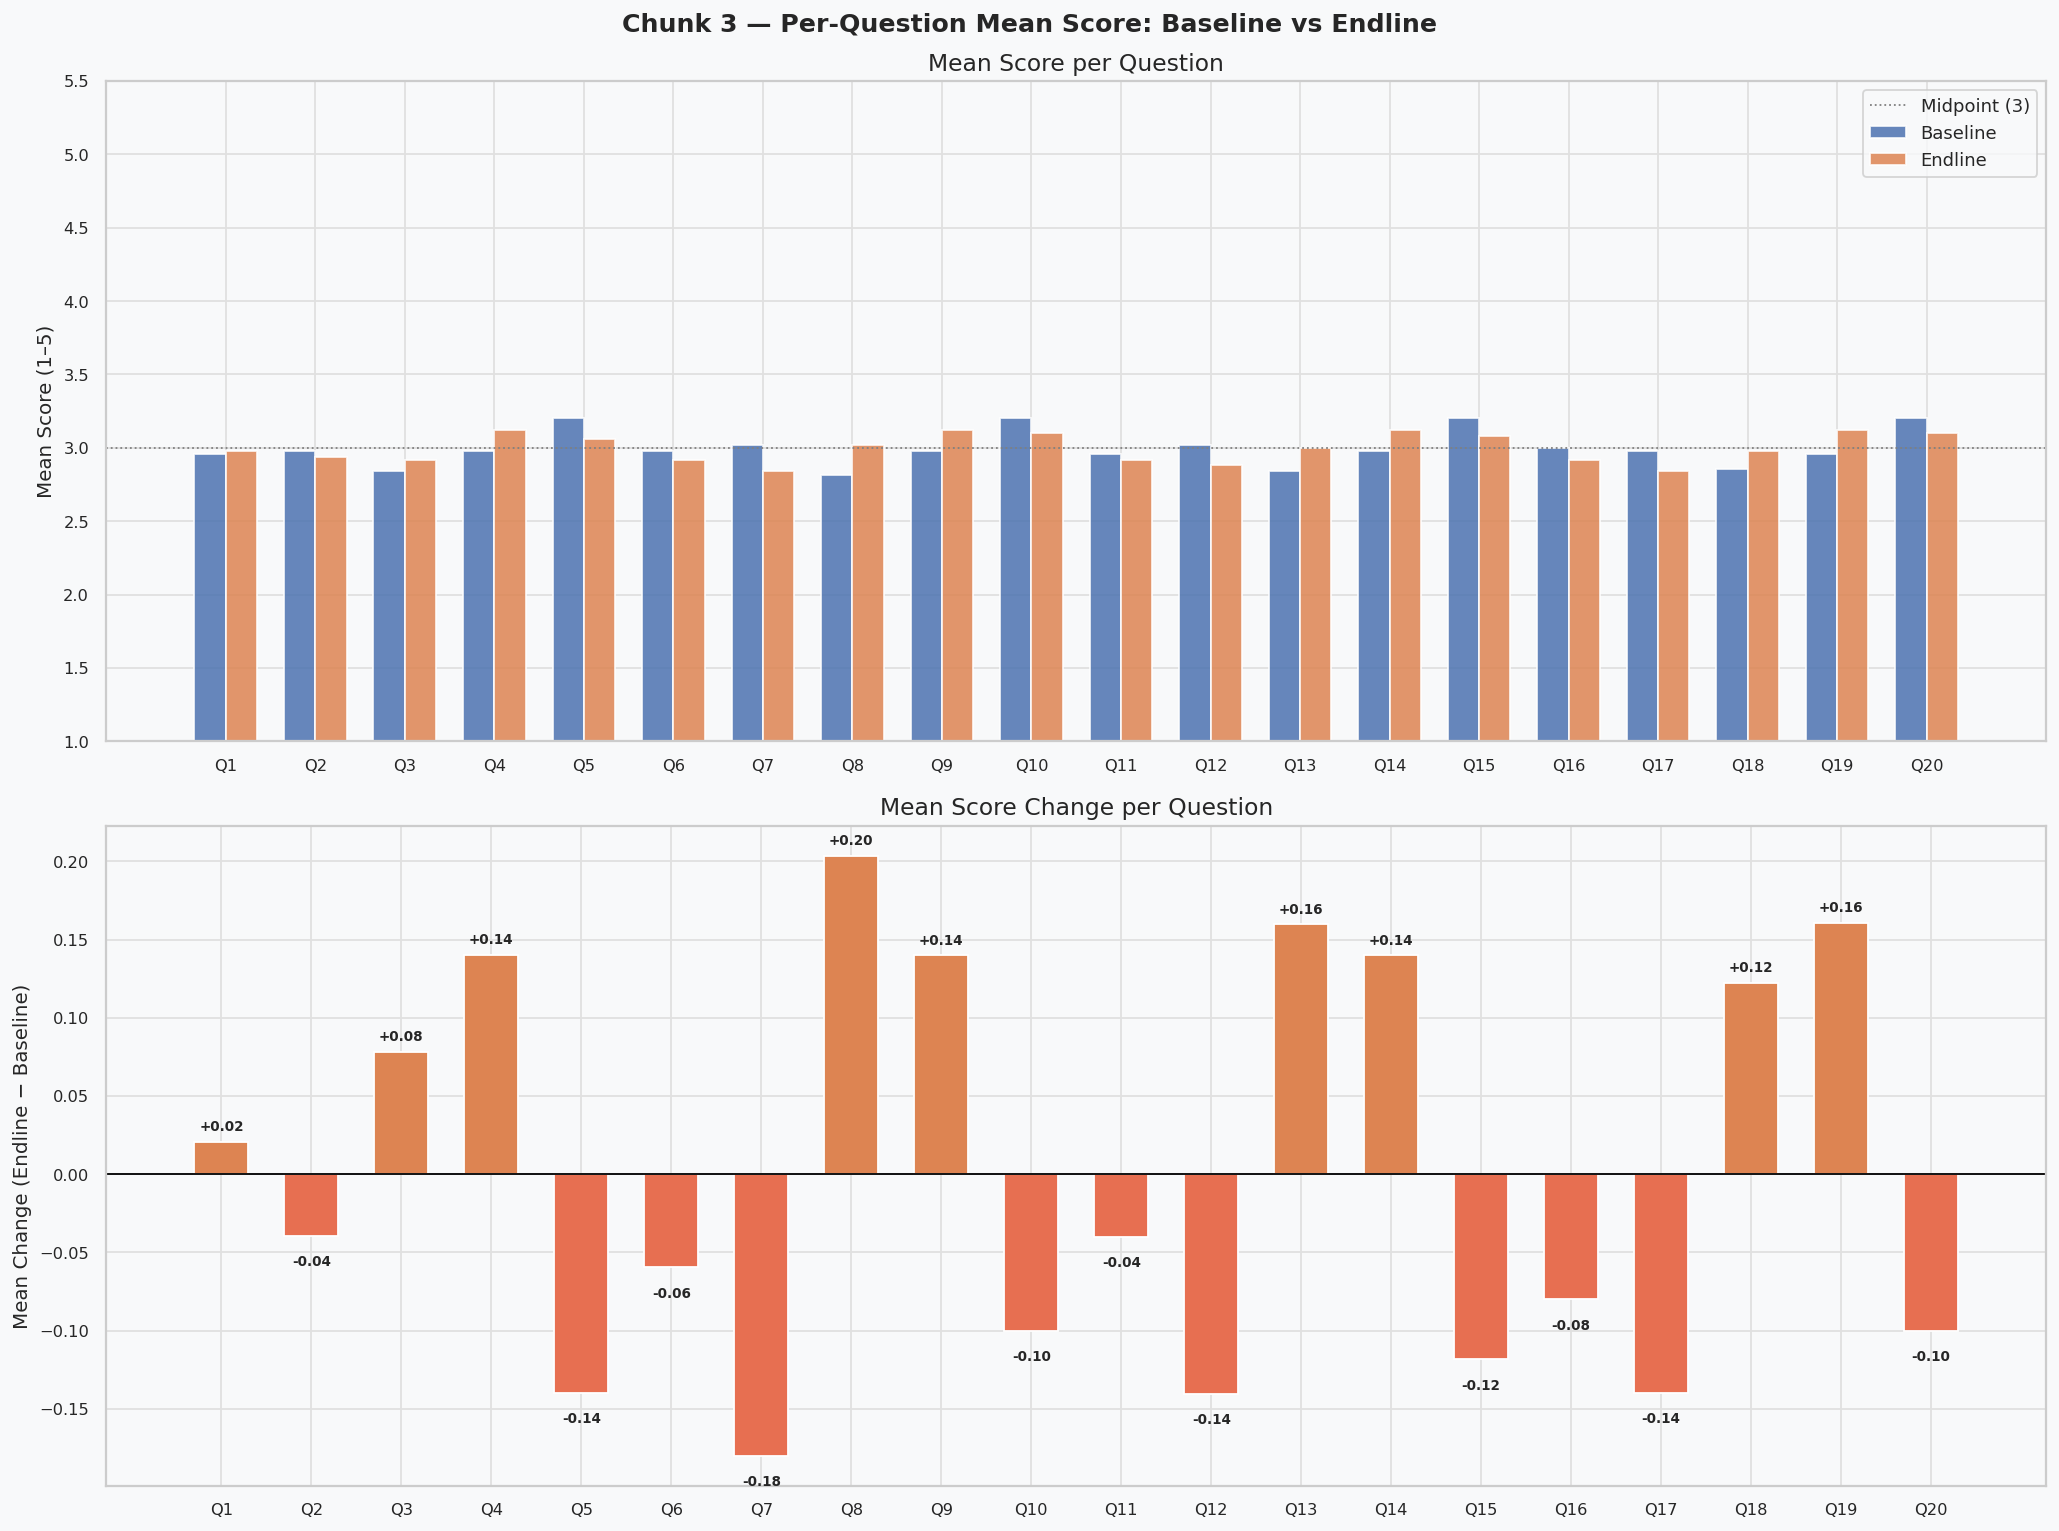

💡 Insight: Q8 ('I can sound out new words') showed the most improvement (+0.204).
   Q7 ('I understand what I read') declined the most (-0.180).


In [10]:


# =============================================================================
# CHUNK 3 — Per-Question Mean Score: Baseline vs Endline
# Insight: Which specific questions improved or declined?
# =============================================================================

q_mean_b = [df[f"b_{q_slug[i]}"].mean() for i in range(1, 21)]
q_mean_e = [df[f"e_{q_slug[i]}"].mean() for i in range(1, 21)]
q_diff   = [e - b for b, e in zip(q_mean_b, q_mean_e)]
short_labels = [f"Q{i}\n{q_labels[i][:22]}…" if len(q_labels[i]) > 22 else f"Q{i}\n{q_labels[i]}" for i in range(1, 21)]

fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle("Chunk 3 — Per-Question Mean Score: Baseline vs Endline",
             fontsize=14, fontweight="bold")

# Top: Grouped bars
ax = axes[0]
x = np.arange(20)
w = 0.35
ax.bar(x - w/2, q_mean_b, width=w, color=PALETTE[0], alpha=0.85, label="Baseline", edgecolor="white")
ax.bar(x + w/2, q_mean_e, width=w, color=PALETTE[1], alpha=0.85, label="Endline",  edgecolor="white")
ax.set_xticks(x)
ax.set_xticklabels([f"Q{i}" for i in range(1, 21)])
ax.set_ylabel("Mean Score (1–5)")
ax.set_ylim(1, 5.5)
ax.axhline(3, color="gray", linestyle=":", linewidth=1, label="Midpoint (3)")
ax.set_title("Mean Score per Question")
ax.legend()

# Bottom: Change bar (red/green)
ax = axes[1]
bar_colors = [PALETTE[1] if d >= 0 else "#E76F51" for d in q_diff]
bars = ax.bar(x, q_diff, color=bar_colors, edgecolor="white", width=0.6)
ax.axhline(0, color="black", linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels([f"Q{i}" for i in range(1, 21)])
ax.set_ylabel("Mean Change (Endline − Baseline)")
ax.set_title("Mean Score Change per Question")
for bar, val in zip(bars, q_diff):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.005 if val >= 0 else -0.012),
            f"{val:+.2f}", ha="center", va="bottom" if val >= 0 else "top", fontsize=7.5, fontweight="bold")

plt.tight_layout()
plt.savefig("chunk3_per_question_scores.png", bbox_inches="tight")
plt.show()
top_imp = np.argmax(q_diff) + 1
top_dec = np.argmin(q_diff) + 1
print(f"💡 Insight: Q{top_imp} ('{q_labels[top_imp]}') showed the most improvement (+{max(q_diff):.3f}).")
print(f"   Q{top_dec} ('{q_labels[top_dec]}') declined the most ({min(q_diff):.3f}).")

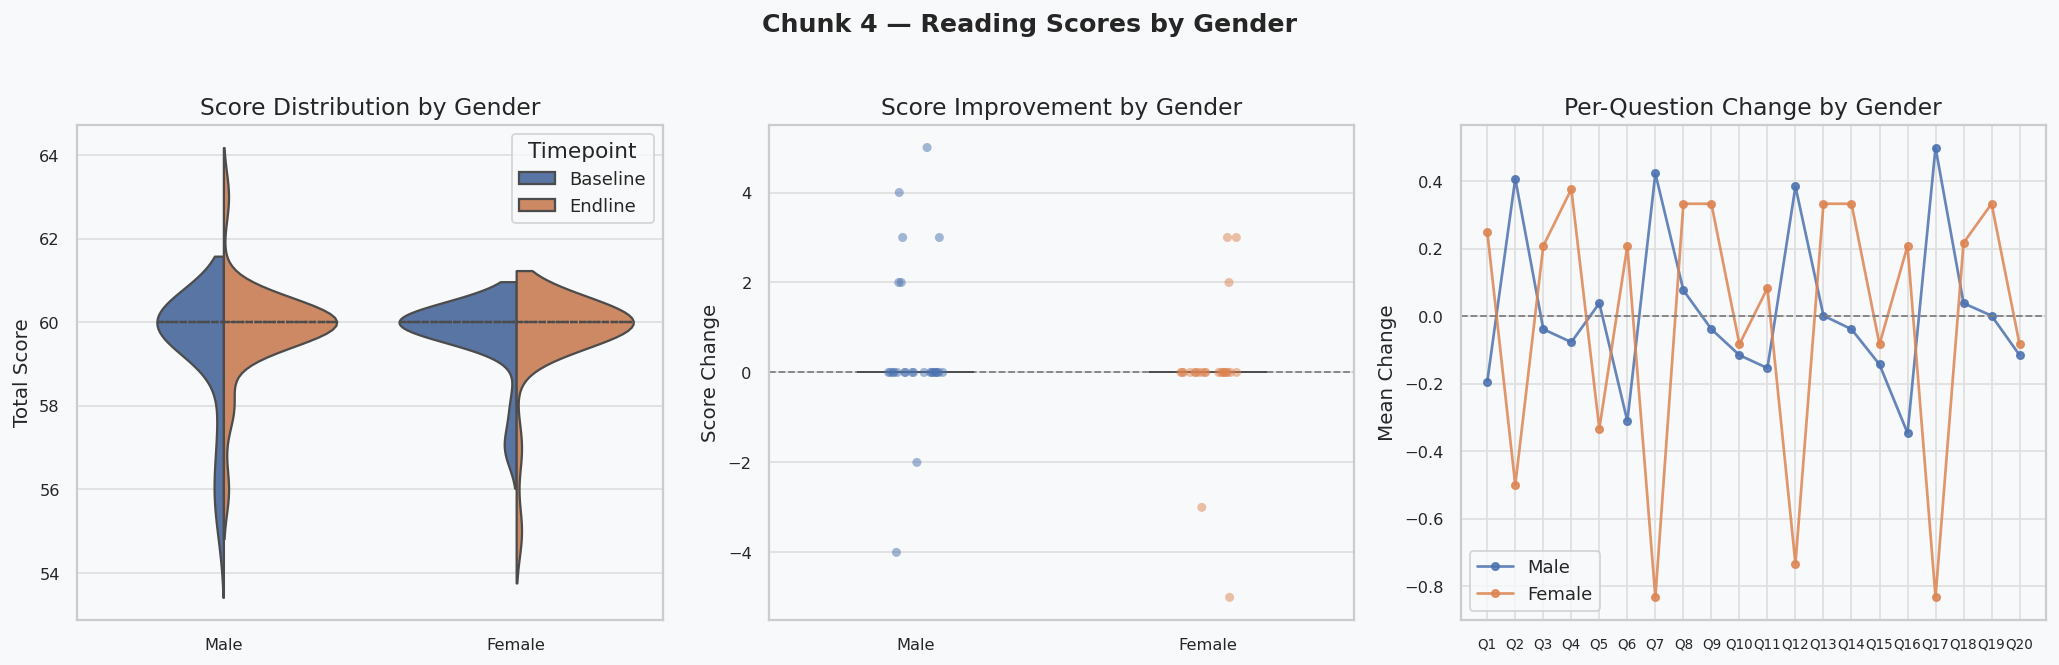

  Male: baseline=59.3, endline=59.8, change=+0.50
  Female: baseline=59.7, endline=59.7, change=+0.00
💡 Insight: Compare whether one gender group consistently improved on more questions.


In [11]:
# =============================================================================
# CHUNK 4 — Score by Gender
# Insight: Are there score or improvement differences between genders?
# =============================================================================

gender_df = df[df["gender"].isin(["Male", "Female"])].copy()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Chunk 4 — Reading Scores by Gender", fontsize=14, fontweight="bold", y=1.02)

# Left: Baseline vs endline total by gender (violin)
ax = axes[0]
melted = pd.melt(gender_df, id_vars=["gender"],
                 value_vars=["baseline_total", "endline_total"],
                 var_name="Timepoint", value_name="Total Score")
melted["Timepoint"] = melted["Timepoint"].map({"baseline_total": "Baseline", "endline_total": "Endline"})
sns.violinplot(data=melted, x="gender", y="Total Score", hue="Timepoint",
               palette=PALETTE, split=True, inner="quart", ax=ax)
ax.set_title("Score Distribution by Gender")
ax.set_xlabel("")

# Middle: Improvement by gender (boxplot + strip)
ax = axes[1]
sns.boxplot(data=gender_df, x="gender", y="improvement", hue="gender",
            palette={"Male": PALETTE[0], "Female": PALETTE[1]},
            width=0.4, fliersize=0, legend=False, ax=ax)
sns.stripplot(data=gender_df, x="gender", y="improvement", hue="gender",
              palette={"Male": PALETTE[0], "Female": PALETTE[1]},
              size=5, alpha=0.5, jitter=True, legend=False, ax=ax)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_title("Score Improvement by Gender")
ax.set_xlabel("")
ax.set_ylabel("Score Change")

# Right: Per-question mean change by gender (heatmap-style bar)
ax = axes[2]
for g, color in zip(["Male", "Female"], PALETTE):
    sub = gender_df[gender_df["gender"] == g]
    diffs = [sub[f"e_{q_slug[i]}"].mean() - sub[f"b_{q_slug[i]}"].mean() for i in range(1, 21)]
    ax.plot(range(1, 21), diffs, marker="o", markersize=4, linewidth=1.5,
            color=color, label=g, alpha=0.85)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_xticks(range(1, 21))
ax.set_xticklabels([f"Q{i}" for i in range(1, 21)], fontsize=7.5)
ax.set_ylabel("Mean Change")
ax.set_title("Per-Question Change by Gender")
ax.legend()

plt.tight_layout()
plt.savefig("chunk4_gender_analysis.png", bbox_inches="tight")
plt.show()
for g in ["Male", "Female"]:
    sub = gender_df[gender_df["gender"] == g]
    print(f"  {g}: baseline={sub['baseline_total'].mean():.1f}, endline={sub['endline_total'].mean():.1f}, "
          f"change={sub['improvement'].mean():+.2f}")
print("💡 Insight: Compare whether one gender group consistently improved on more questions.")

/tmp/ipython-input-2910591593.py:32: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=age_df, x="age_group", y="improvement", hue="age_group", order=age_groups,
/tmp/ipython-input-2910591593.py:34: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=age_df, x="age_group", y="improvement", hue="age_group", order=age_groups,


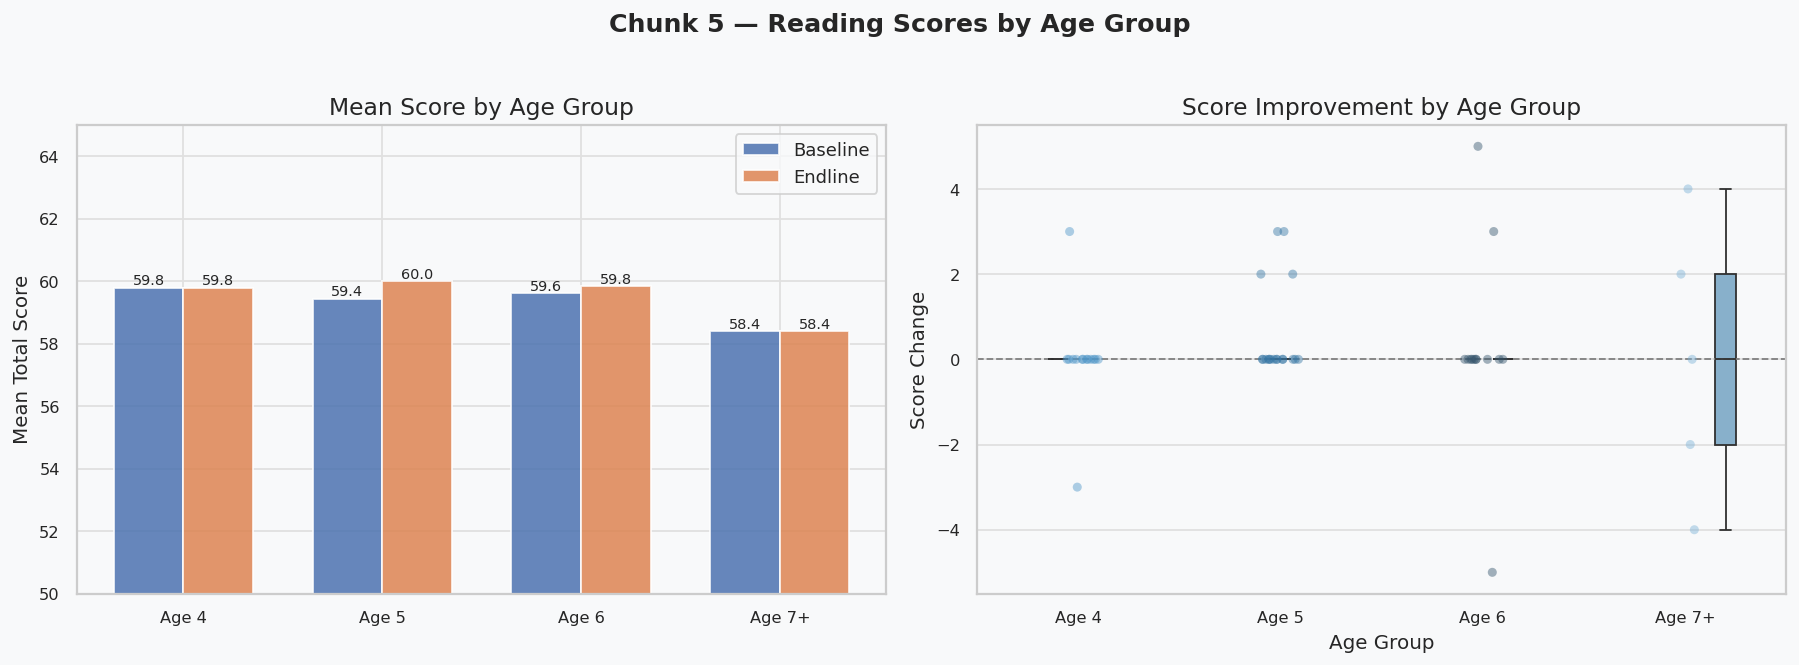

💡 Insight: Age 5 children showed the most improvement on average. 
   Age 7+ participants scored highest overall but near ceiling at baseline — less room to grow.


In [12]:
# =============================================================================
# CHUNK 5 — Score by Age Group
# Insight: Do older children score higher? Do younger children improve more?
# =============================================================================

age_groups = ["Age 4", "Age 5", "Age 6", "Age 7+"]
age_df = df[df["age_group"].isin(age_groups)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Chunk 5 — Reading Scores by Age Group", fontsize=14, fontweight="bold", y=1.02)

# Left: baseline + endline grouped by age
ax = axes[0]
age_means = age_df.groupby("age_group", observed=True)[["baseline_total", "endline_total"]].mean()
x = np.arange(len(age_means))
w = 0.35
ax.bar(x - w/2, age_means["baseline_total"], width=w, color=PALETTE[0], alpha=0.85, label="Baseline", edgecolor="white")
ax.bar(x + w/2, age_means["endline_total"],  width=w, color=PALETTE[1], alpha=0.85, label="Endline",  edgecolor="white")
ax.set_xticks(x)
ax.set_xticklabels(age_means.index)
ax.set_ylabel("Mean Total Score")
ax.set_ylim(50, 65)
ax.set_title("Mean Score by Age Group")
ax.legend()
for i, (b, e) in enumerate(zip(age_means["baseline_total"], age_means["endline_total"])):
    ax.text(i - w/2, b + 0.1, f"{b:.1f}", ha="center", fontsize=8)
    ax.text(i + w/2, e + 0.1, f"{e:.1f}", ha="center", fontsize=8)

# Right: Improvement distribution by age group
ax = axes[1]
age_palette = sns.color_palette("Blues_d", len(age_groups))
sns.boxplot(data=age_df, x="age_group", y="improvement", hue="age_group", order=age_groups,
            palette=age_palette, width=0.5, fliersize=0, legend=False, ax=ax)
sns.stripplot(data=age_df, x="age_group", y="improvement", hue="age_group", order=age_groups,
              palette=age_palette, size=5, alpha=0.45, jitter=True, legend=False, ax=ax)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_title("Score Improvement by Age Group")
ax.set_xlabel("Age Group")
ax.set_ylabel("Score Change")

plt.tight_layout()
plt.savefig("chunk5_age_analysis.png", bbox_inches="tight")
plt.show()
print("💡 Insight: Age 5 children showed the most improvement on average.",
      "\n   Age 7+ participants scored highest overall but near ceiling at baseline — less room to grow.")

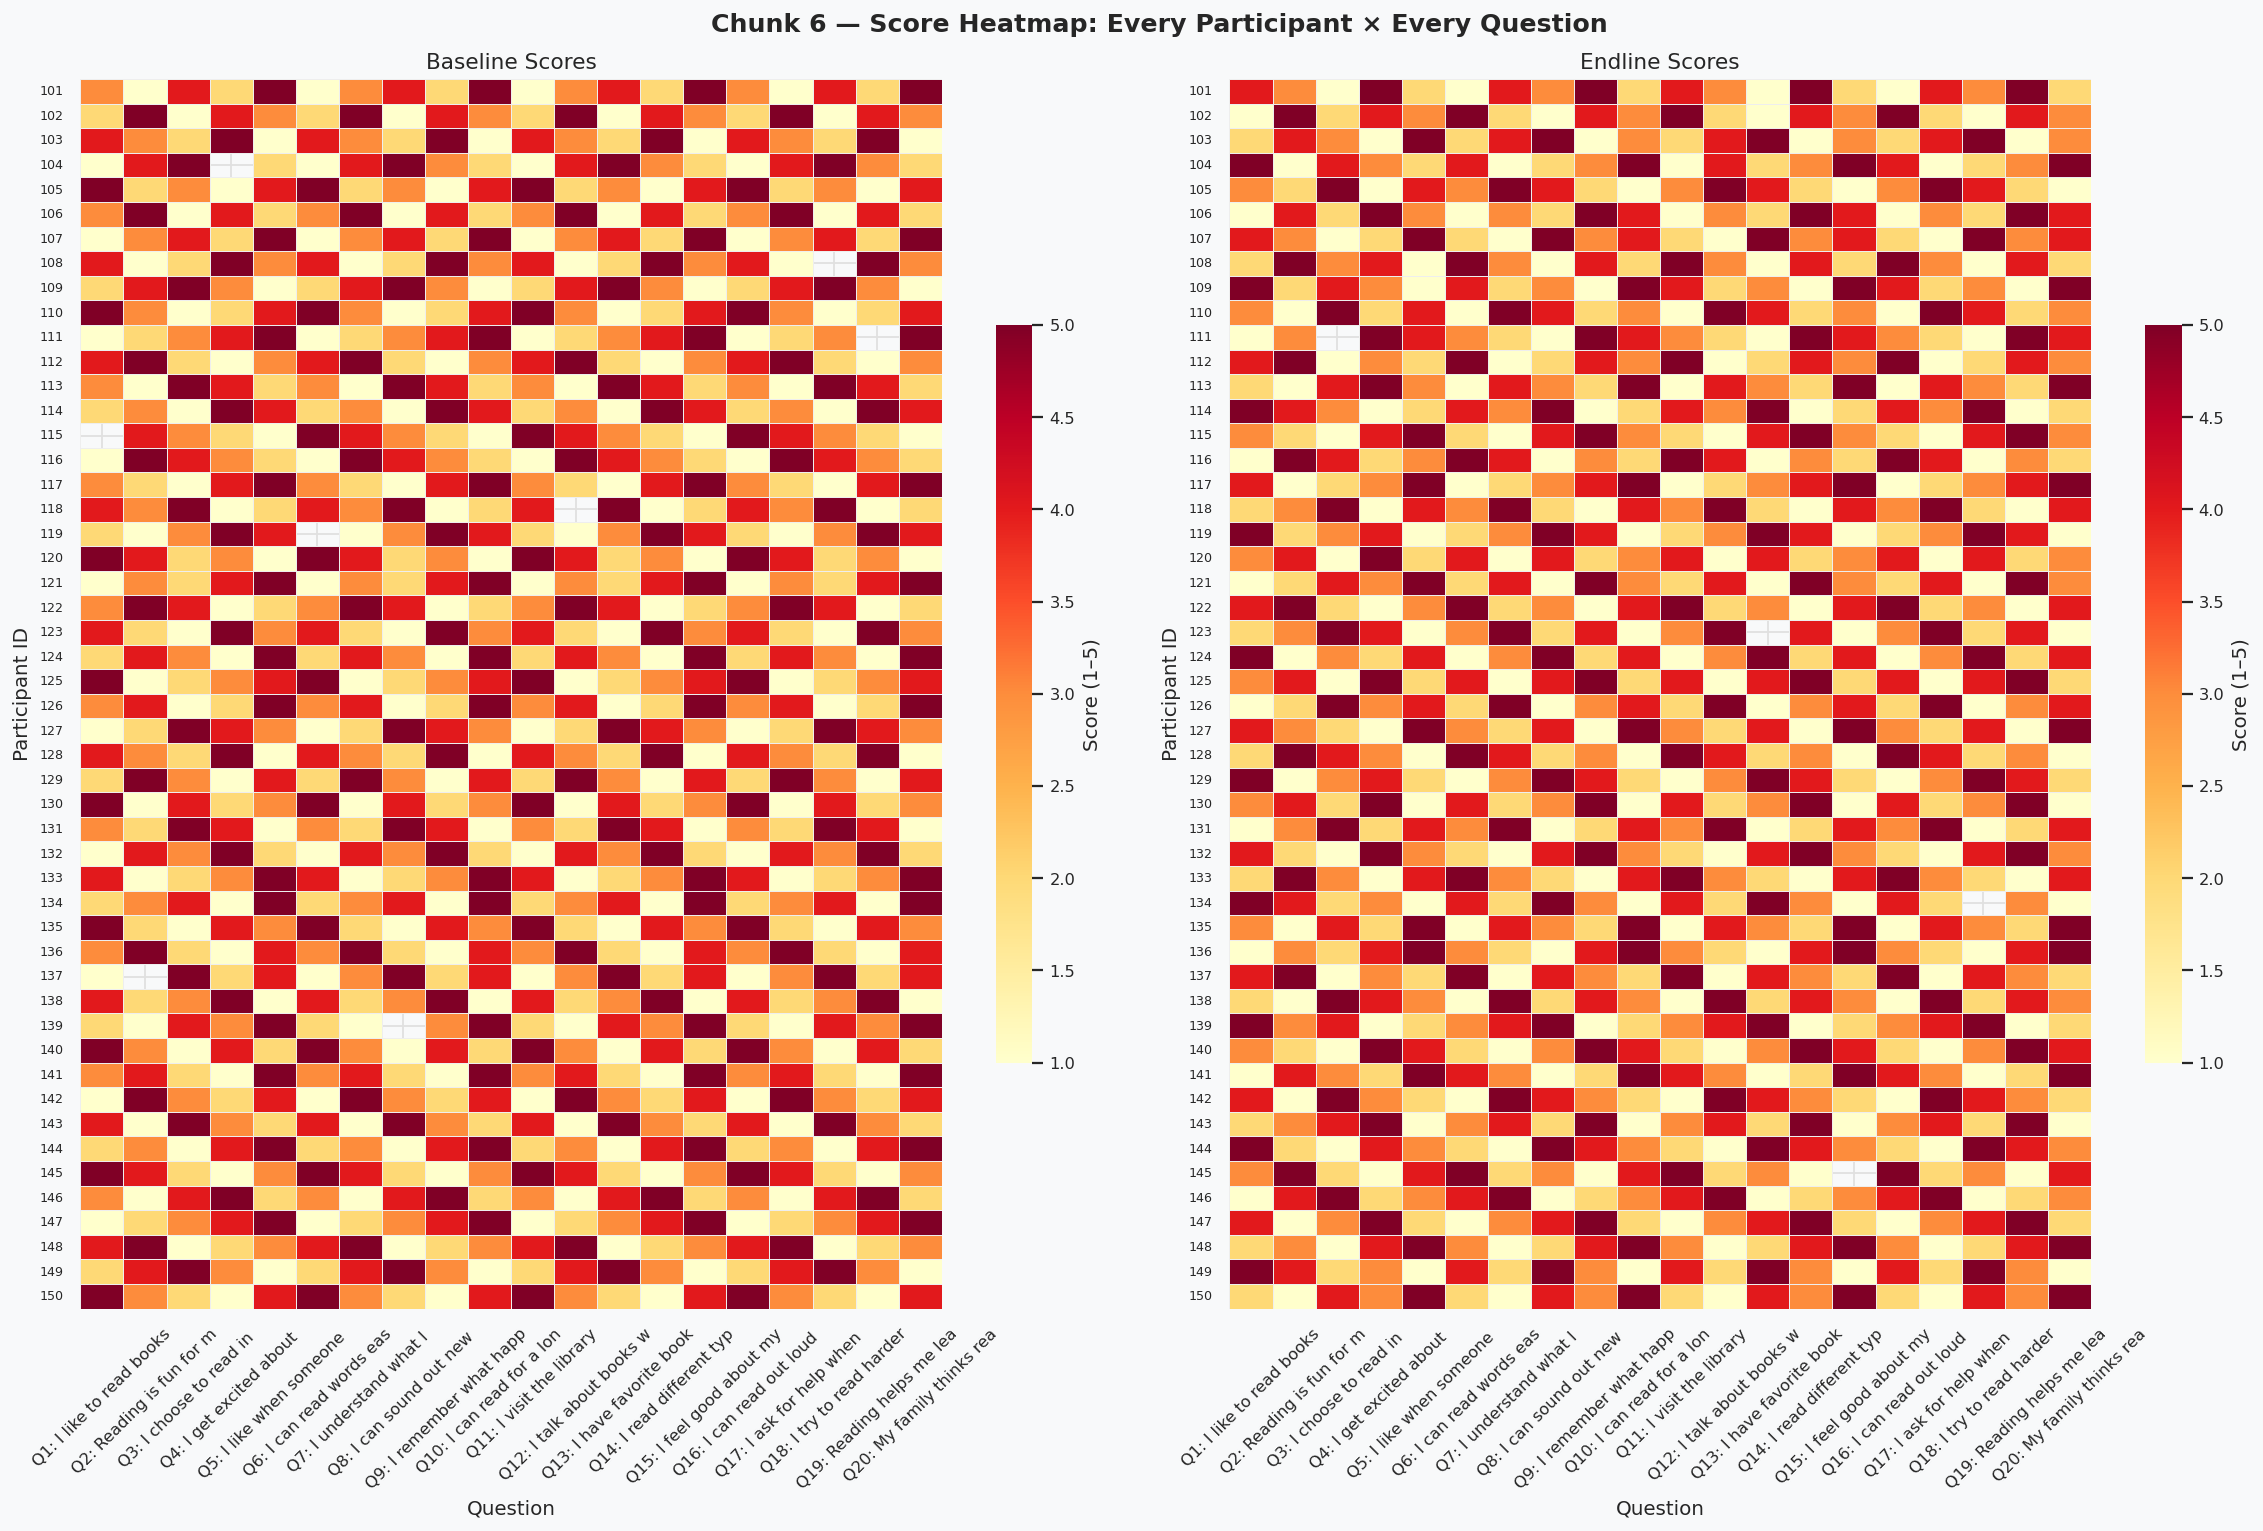

💡 Insight: The heatmap reveals whether any questions consistently score low/high across all participants.
   Look for columns that are uniformly dark (high) or light (low) at both timepoints.


In [13]:


# =============================================================================
# CHUNK 6 — Heatmap: Per-Question Score by Participant
# Insight: Full view of where each participant scored high/low
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 12))
fig.suptitle("Chunk 6 — Score Heatmap: Every Participant × Every Question",
             fontsize=14, fontweight="bold")

short_q = [f"Q{i}: {q_labels[i][:20]}" for i in range(1, 21)]

for ax, cols, title in [(axes[0], b_cols, "Baseline"), (axes[1], e_cols, "Endline")]:
    heat_df = df[["participant_id"] + cols].set_index("participant_id")
    heat_df.columns = short_q
    sns.heatmap(heat_df, ax=ax, cmap="YlOrRd", vmin=1, vmax=5,
                linewidths=0.3, linecolor="#EEEEEE",
                cbar_kws={"label": "Score (1–5)", "shrink": 0.6})
    ax.set_title(f"{title} Scores", fontsize=12)
    ax.set_xlabel("Question")
    ax.set_ylabel("Participant ID")
    ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="y", labelsize=7)

plt.tight_layout()
plt.savefig("chunk6_heatmap.png", bbox_inches="tight")
plt.show()
print("💡 Insight: The heatmap reveals whether any questions consistently score low/high across all participants.")
print("   Look for columns that are uniformly dark (high) or light (low) at both timepoints.")

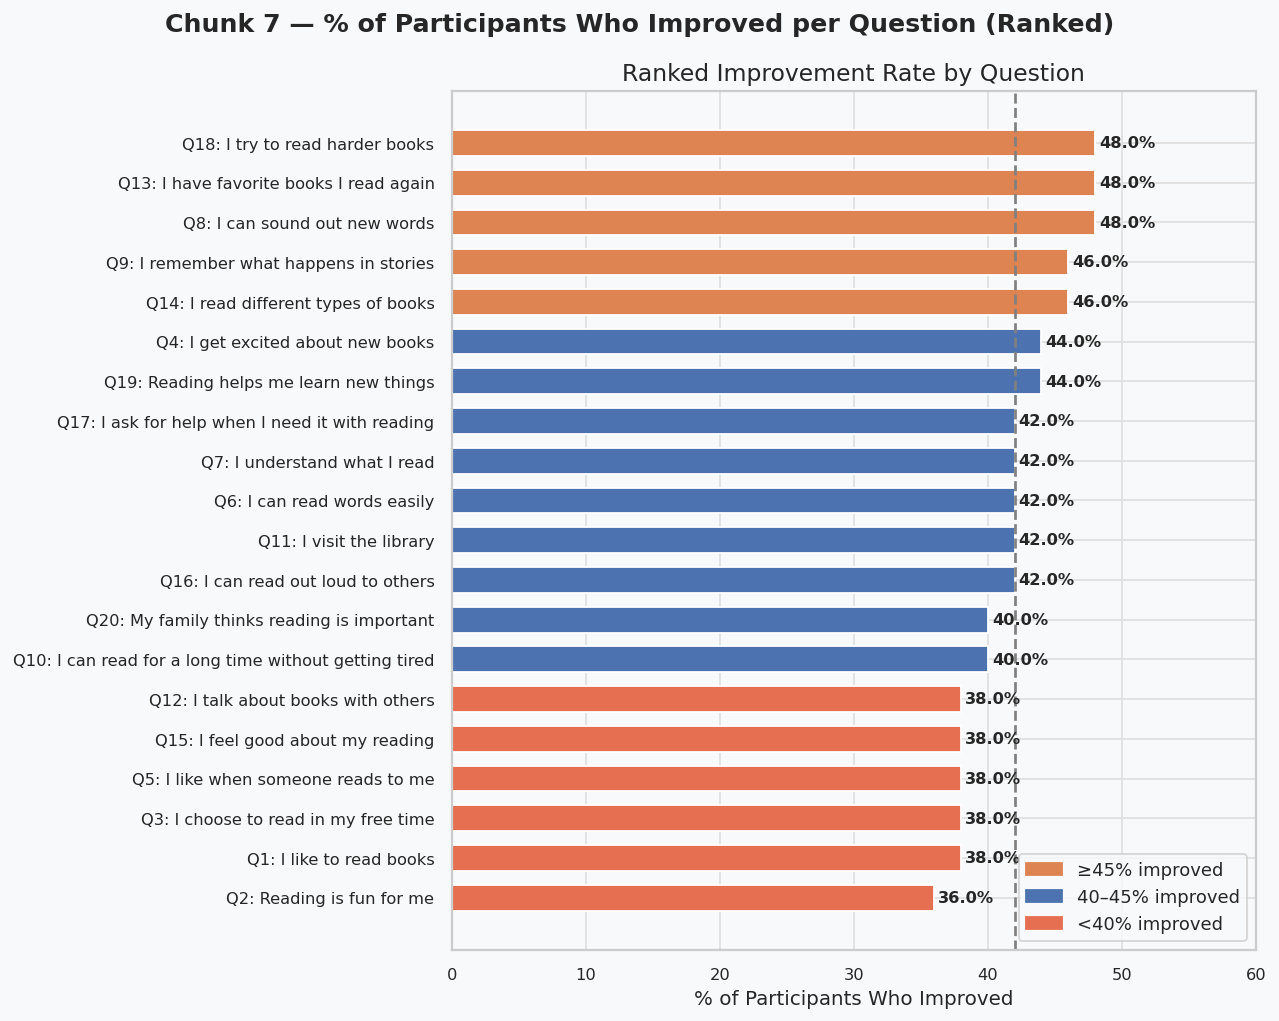

💡 Insight:
   Top 3 most-improved questions: ['Q8: I can sound out new words', 'Q13: I have favorite books I read again', 'Q18: I try to read harder books']
   Bottom 3 least-improved questions: ['Q2: Reading is fun for me', 'Q1: I like to read books', 'Q3: I choose to read in my free time']


In [14]:
# =============================================================================
# CHUNK 7 — Improvement % per Question (Ranked)
# Insight: Which questions are the easiest and hardest to improve on?
# =============================================================================

imp_pct = [(df[f"e_{q_slug[i]}"] > df[f"b_{q_slug[i]}"]).mean() * 100 for i in range(1, 21)]
imp_df  = pd.DataFrame({
    "question": [f"Q{i}: {q_labels[i]}" for i in range(1, 21)],
    "improvement_pct": imp_pct
}).sort_values("improvement_pct", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Chunk 7 — % of Participants Who Improved per Question (Ranked)",
             fontsize=14, fontweight="bold")

colors = [PALETTE[1] if v >= 45 else (PALETTE[0] if v >= 40 else "#E76F51") for v in imp_df["improvement_pct"]]
bars = ax.barh(imp_df["question"], imp_df["improvement_pct"], color=colors, edgecolor="white", height=0.65)
ax.axvline(imp_df["improvement_pct"].mean(), color="gray", linestyle="--", linewidth=1.5,
           label=f"Mean: {imp_df['improvement_pct'].mean():.1f}%")
for bar, val in zip(bars, imp_df["improvement_pct"]):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%", va="center", fontsize=9, fontweight="bold")
ax.set_xlabel("% of Participants Who Improved")
ax.set_title("Ranked Improvement Rate by Question")
ax.set_xlim(0, 60)
ax.legend()

high_patch = mpatches.Patch(color=PALETTE[1], label="≥45% improved")
mid_patch  = mpatches.Patch(color=PALETTE[0], label="40–45% improved")
low_patch  = mpatches.Patch(color="#E76F51",  label="<40% improved")
ax.legend(handles=[high_patch, mid_patch, low_patch])

plt.tight_layout()
plt.savefig("chunk7_improvement_ranked.png", bbox_inches="tight")
plt.show()
top3 = imp_df.tail(3)["question"].tolist()
bot3 = imp_df.head(3)["question"].tolist()
print("💡 Insight:")
print(f"   Top 3 most-improved questions: {top3}")
print(f"   Bottom 3 least-improved questions: {bot3}")



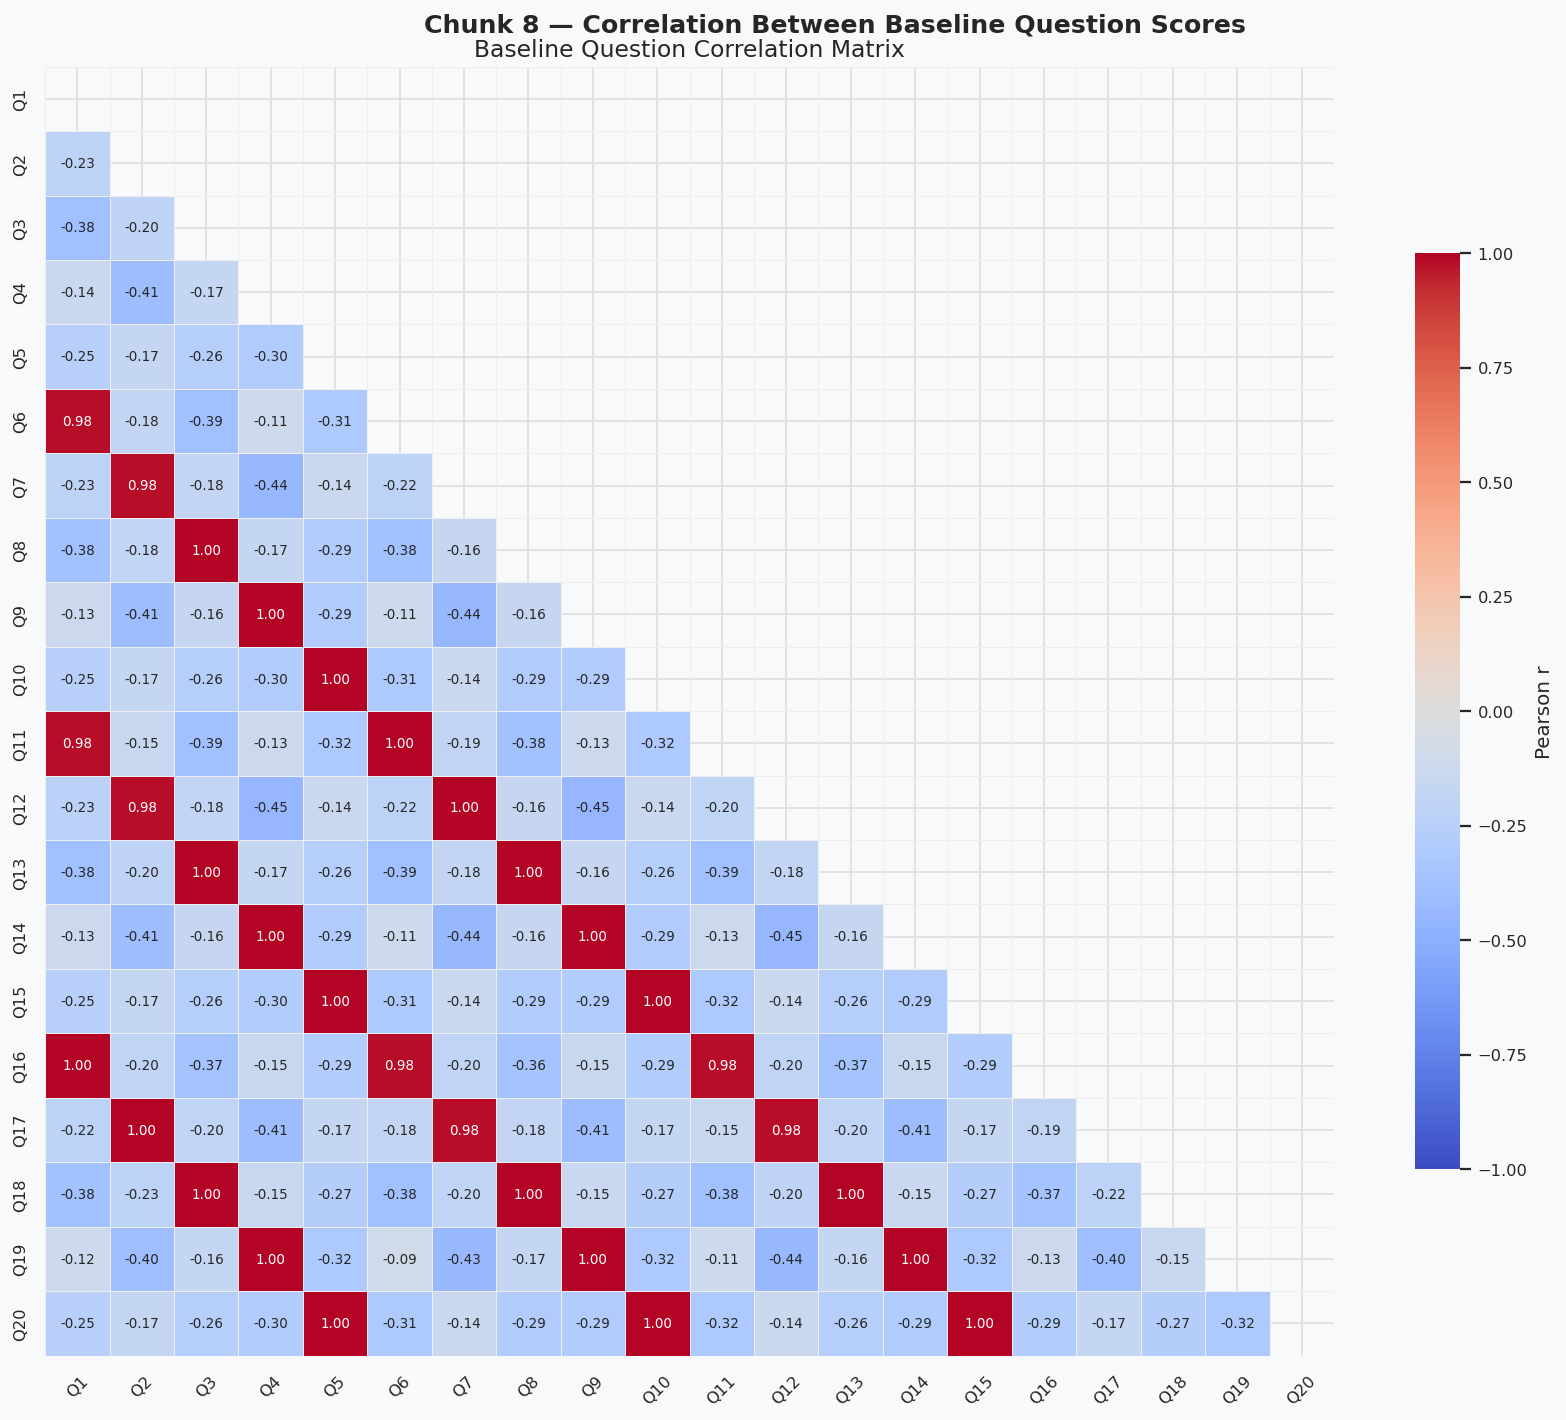

💡 Insight: Strongest correlation at baseline: Q16 & Q11 (r=0.98)
   Highly correlated questions may measure the same underlying construct.


In [15]:
# =============================================================================
# CHUNK 8 — Correlation Matrix: Baseline Question Scores
# Insight: Are certain reading attitudes/skills correlated with each other?
# =============================================================================

fig, ax = plt.subplots(figsize=(13, 11))
fig.suptitle("Chunk 8 — Correlation Between Baseline Question Scores",
             fontsize=14, fontweight="bold")

corr = df[b_cols].copy()
corr.columns = [f"Q{i}" for i in range(1, 21)]
mask = np.triu(np.ones_like(corr.corr(), dtype=bool))
sns.heatmap(corr.corr(), ax=ax, mask=mask, cmap="coolwarm", center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.4, linecolor="#EEEEEE",
            annot=True, fmt=".2f", annot_kws={"size": 7.5},
            cbar_kws={"label": "Pearson r", "shrink": 0.7})
ax.set_title("Baseline Question Correlation Matrix")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("chunk8_correlation.png", bbox_inches="tight")
plt.show()
corr_vals = corr.corr().abs().unstack()
corr_vals = corr_vals[corr_vals < 1].sort_values(ascending=False)
top_pair = corr_vals.index[0]
print(f"💡 Insight: Strongest correlation at baseline: {top_pair[0]} & {top_pair[1]} (r={corr_vals.iloc[0]:.2f})")
print("   Highly correlated questions may measure the same underlying construct.")



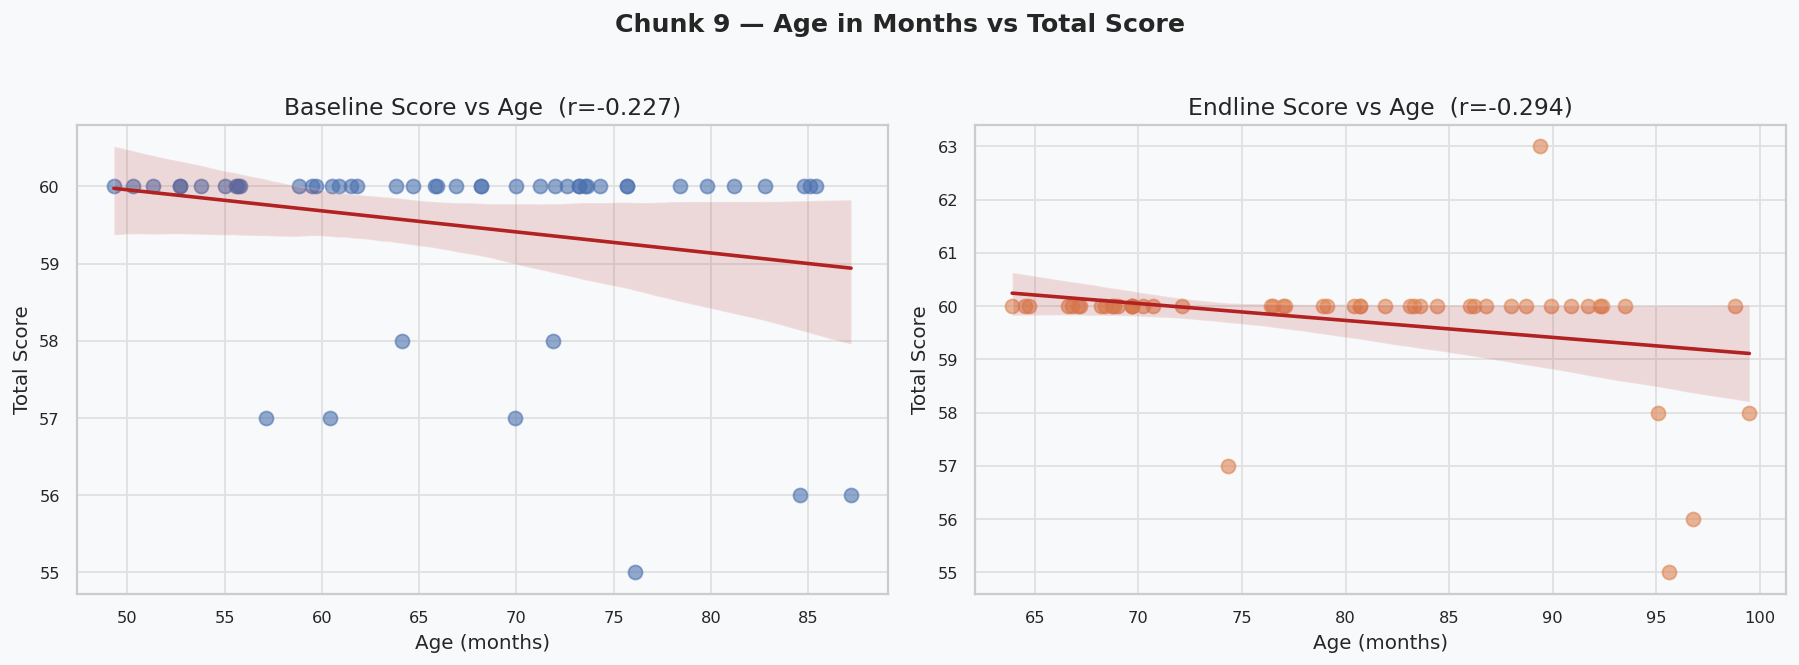

💡 Insight: Correlation (age vs baseline score): r=-0.227
   Correlation (age vs endline score): r=-0.294
   A near-zero r suggests age alone does not predict reading score in this sample.


In [16]:
# =============================================================================
# CHUNK 9 — Age vs Score Scatter
# Insight: Is there a relationship between age and reading score?
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Chunk 9 — Age in Months vs Total Score", fontsize=14, fontweight="bold", y=1.02)

for ax, col, ts_col, title, color in [
    (axes[0], "baseline_total", "age_months_baseline", "Baseline", PALETTE[0]),
    (axes[1], "endline_total",  "age_months_endline",  "Endline",  PALETTE[1])
]:
    sns.regplot(data=df, x=ts_col, y=col, ax=ax,
                scatter_kws={"alpha": 0.6, "s": 60, "color": color},
                line_kws={"color": "firebrick", "linewidth": 2},
                color=color)
    r = df[ts_col].corr(df[col])
    ax.set_title(f"{title} Score vs Age  (r={r:.3f})")
    ax.set_xlabel("Age (months)")
    ax.set_ylabel("Total Score")

plt.tight_layout()
plt.savefig("chunk9_age_scatter.png", bbox_inches="tight")
plt.show()
r_b = df["age_months_baseline"].corr(df["baseline_total"])
r_e = df["age_months_endline"].corr(df["endline_total"])
print(f"💡 Insight: Correlation (age vs baseline score): r={r_b:.3f}")
print(f"   Correlation (age vs endline score): r={r_e:.3f}")
print("   A near-zero r suggests age alone does not predict reading score in this sample.")



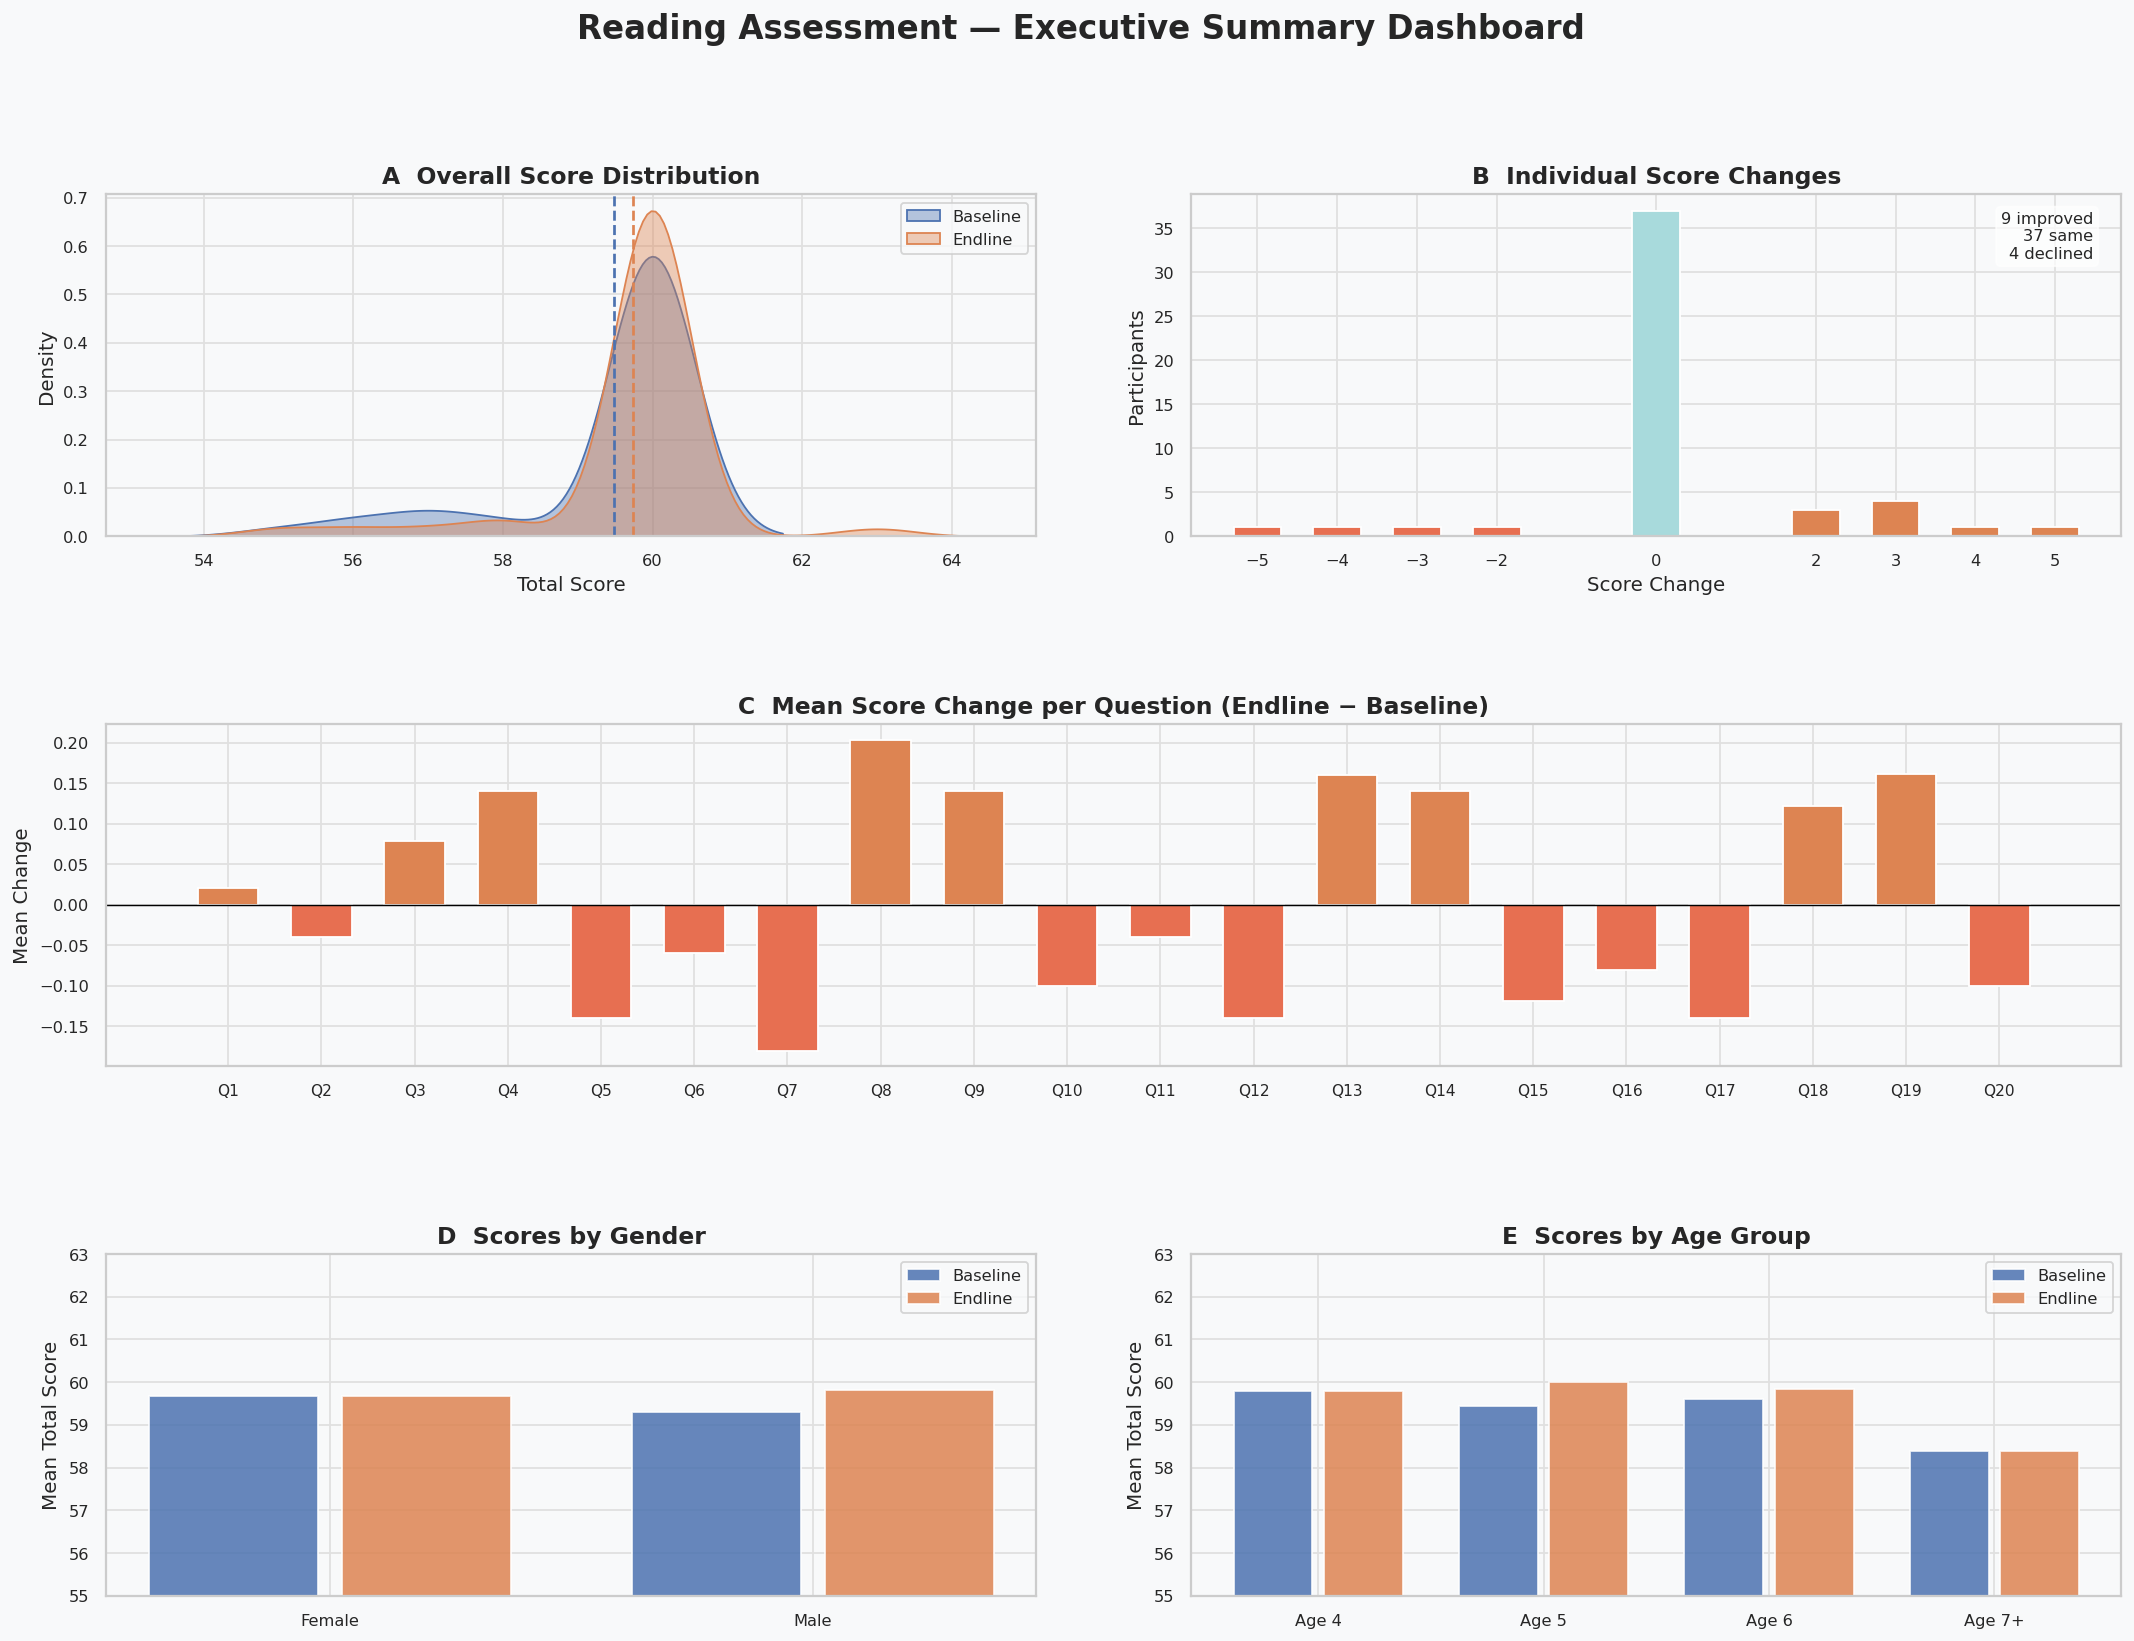


FINAL SUMMARY — KEY FINDINGS

Sample:        50 participants  |  {'Male': 26, 'Female': 24}
Age range:     49–87 months at baseline

Overall scores
  Baseline mean : 59.48 / 100
  Endline mean  : 59.74 / 100
  Net change    : +0.26 points on average

Participants
  Improved  : 9 (18%)
  No change : 37 (74%)
  Declined  : 4 (8%)

Most improved question : Q8 — I can sound out new words (+0.204)
Most declined question : Q7 — I understand what I read (-0.180)

Gender (Male vs Female)
  Male   improvement : +0.50
  Female improvement : +0.00

Age correlation with improvement : r = -0.038

Output PNGs saved: chunk1 through chunk10_dashboard.png


In [17]:
# =============================================================================
# CHUNK 10 — FINAL SUMMARY DASHBOARD
# End result: Single-page overview of all key findings
# =============================================================================

fig = plt.figure(figsize=(20, 14))
fig.patch.set_facecolor(BG)
fig.suptitle("Reading Assessment — Executive Summary Dashboard",
             fontsize=18, fontweight="bold", y=0.98)

gs = GridSpec(3, 4, figure=fig, hspace=0.55, wspace=0.4)

# ── Panel A: Score shift KDE ──────────────────────────────────────────────────
ax_a = fig.add_subplot(gs[0, :2])
sns.kdeplot(df["baseline_total"], ax=ax_a, color=PALETTE[0], fill=True, alpha=0.4, label="Baseline")
sns.kdeplot(df["endline_total"],  ax=ax_a, color=PALETTE[1], fill=True, alpha=0.4, label="Endline")
ax_a.axvline(df["baseline_total"].mean(), color=PALETTE[0], linestyle="--", linewidth=1.5)
ax_a.axvline(df["endline_total"].mean(),  color=PALETTE[1], linestyle="--", linewidth=1.5)
ax_a.set_title("A  Overall Score Distribution", fontweight="bold")
ax_a.set_xlabel("Total Score"); ax_a.legend(fontsize=9)

# ── Panel B: Improvement distribution ────────────────────────────────────────
ax_b = fig.add_subplot(gs[0, 2:])
imp_counts = df["improvement"].value_counts().sort_index()
bar_colors = [PALETTE[1] if i > 0 else ("#A8DADC" if i == 0 else "#E76F51") for i in imp_counts.index]
ax_b.bar(imp_counts.index, imp_counts.values, color=bar_colors, edgecolor="white", width=0.6)
ax_b.set_title("B  Individual Score Changes", fontweight="bold")
ax_b.set_xlabel("Score Change"); ax_b.set_ylabel("Participants")
ax_b.set_xticks(imp_counts.index)
n_imp = (df["improvement"] > 0).sum()
ax_b.annotate(f"{n_imp} improved\n{(df['improvement']==0).sum()} same\n{(df['improvement']<0).sum()} declined",
              xy=(0.97, 0.95), xycoords="axes fraction", ha="right", va="top",
              fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

# ── Panel C: Per-question change ──────────────────────────────────────────────
ax_c = fig.add_subplot(gs[1, :])
bar_colors_q = [PALETTE[1] if d >= 0 else "#E76F51" for d in q_diff]
ax_c.bar(range(1, 21), q_diff, color=bar_colors_q, edgecolor="white", width=0.65)
ax_c.axhline(0, color="black", linewidth=0.8)
ax_c.set_xticks(range(1, 21))
ax_c.set_xticklabels([f"Q{i}" for i in range(1, 21)], fontsize=8.5)
ax_c.set_title("C  Mean Score Change per Question (Endline − Baseline)", fontweight="bold")
ax_c.set_ylabel("Mean Change")

# ── Panel D: Gender comparison ────────────────────────────────────────────────
ax_d = fig.add_subplot(gs[2, :2])
gender_means = gender_df.groupby("gender")[["baseline_total", "endline_total"]].mean()
x = np.arange(len(gender_means))
ax_d.bar(x - 0.2, gender_means["baseline_total"], width=0.35, color=PALETTE[0], alpha=0.85, label="Baseline", edgecolor="white")
ax_d.bar(x + 0.2, gender_means["endline_total"],  width=0.35, color=PALETTE[1], alpha=0.85, label="Endline",  edgecolor="white")
ax_d.set_xticks(x); ax_d.set_xticklabels(gender_means.index)
ax_d.set_ylim(55, 63); ax_d.set_title("D  Scores by Gender", fontweight="bold")
ax_d.set_ylabel("Mean Total Score"); ax_d.legend(fontsize=9)

# ── Panel E: Age group comparison ────────────────────────────────────────────
ax_e = fig.add_subplot(gs[2, 2:])
age_means2 = age_df.groupby("age_group", observed=True)[["baseline_total", "endline_total", "improvement"]].mean()
x2 = np.arange(len(age_means2))
ax_e.bar(x2 - 0.2, age_means2["baseline_total"], width=0.35, color=PALETTE[0], alpha=0.85, label="Baseline", edgecolor="white")
ax_e.bar(x2 + 0.2, age_means2["endline_total"],  width=0.35, color=PALETTE[1], alpha=0.85, label="Endline",  edgecolor="white")
ax_e.set_xticks(x2); ax_e.set_xticklabels(age_means2.index)
ax_e.set_ylim(55, 63); ax_e.set_title("E  Scores by Age Group", fontweight="bold")
ax_e.set_ylabel("Mean Total Score"); ax_e.legend(fontsize=9)

plt.savefig("chunk10_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Print final written summary ───────────────────────────────────────────────
print()
print("=" * 70)
print("FINAL SUMMARY — KEY FINDINGS")
print("=" * 70)
print(f"""
Sample:        {len(df)} participants  |  {gender_df['gender'].value_counts().to_dict()}
Age range:     {df['age_months_baseline'].min():.0f}–{df['age_months_baseline'].max():.0f} months at baseline

Overall scores
  Baseline mean : {df['baseline_total'].mean():.2f} / 100
  Endline mean  : {df['endline_total'].mean():.2f} / 100
  Net change    : {df['improvement'].mean():+.2f} points on average

Participants
  Improved  : {(df['improvement']>0).sum()} ({(df['improvement']>0).mean()*100:.0f}%)
  No change : {(df['improvement']==0).sum()} ({(df['improvement']==0).mean()*100:.0f}%)
  Declined  : {(df['improvement']<0).sum()} ({(df['improvement']<0).mean()*100:.0f}%)

Most improved question : Q{np.argmax(q_diff)+1} — {q_labels[np.argmax(q_diff)+1]} (+{max(q_diff):.3f})
Most declined question : Q{np.argmin(q_diff)+1} — {q_labels[np.argmin(q_diff)+1]} ({min(q_diff):.3f})

Gender (Male vs Female)
  Male   improvement : {gender_df[gender_df['gender']=='Male']['improvement'].mean():+.2f}
  Female improvement : {gender_df[gender_df['gender']=='Female']['improvement'].mean():+.2f}

Age correlation with improvement : r = {df['age_months_baseline'].corr(df['improvement']):.3f}
""")
print("=" * 70)
print("Output PNGs saved: chunk1 through chunk10_dashboard.png")